# Hazard class

#### What is a hazard?
A hazard describes weather events such as storms, floods, droughts, or heat waves both in terms of probability of occurrence as well as physical intensity.

<br>

#### How are hazards embedded in the CLIMADA architecture?
Hazards are defined by the base class `Hazard` which gathers the required attributes that enable the impact computation (such as centroids, frequency per event, and intensity per event and centroid) and common methods such as readers and visualization functions. Each hazard class collects historical data or model simulations and transforms them, if necessary, in order to construct a coherent event database. Stochastic events can be generated taking into account the frequency and main intensity characteristics (such as local water depth for floods or gust speed for storms) of historical events, producing an ensemble of probabilistic events for each historical event. CLIMADA provides therefore an event-based probabilistic approach which does not depend on a hypothesis of a priori general probability distribution choices. Note that one can also reduce the probabilistic approach to a deterministic approach (e.g., story-line or forecasting) by defining the frequency to be 1. The source of the historical data (e.g. inventories or satellite images) or model simulations (e.g. synthetic tropical cyclone tracks) and the methodologies used to compute the hazard attributes and its stochastic events depend on each hazard type and are defined in its corresponding Hazard-derived class (e.g. `TropCylcone` for tropical cyclones, explained in the tutorial [TropCyclone](climada_hazard_TropCyclone.ipynb)). This procedure provides a solid and homogeneous methodology to compute impacts worldwide. In the case where the risk analysis comprises a specific region where good quality data or models describing the hazard intensity and frequency are available, these can be directly ingested by the platform through the reader functions, skipping the hazard modelling part (in total or partially), and allowing us to easily and seamlessly combine CLIMADA with external sources. Hence the impact model can be used for a wide variety of applications, e.g. deterministically to assess the impact of a single (past or future) event or to quantify risk based on a (large) set of probabilistic events. Note that since the `Hazard` class is not an abstract class, any hazard that is not defined in CLIMADA can still be used by providing the `Hazard` attributes.

<br>

#### What do hazards look like in CLIMADA?

A `Hazard` contains events of some hazard type defined at `centroids`. There are certain variables in a `Hazard` instance that _are needed_ to compute the impact, while others are _descriptive_ and can therefore be set with default values. The full list of looks like this:

| Mandatory variables &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;| Data Type &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;| Description &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
| :- | :- | :- |
| units |(str)| units of the intensity|
| centroids |`Centroids()`| centroids of the events|
| event_id |(np.array)| id (>0) of each event|
| frequency |(np.array)| frequency of each event in years|
| intensity |(sparse.csr_matrix)| intensity of the events at centroids|
| fraction |(sparse.csr_matrix)| fraction of affected exposures for each event at each centroid|

<br>
<br>

| Descriptive variables | Data Type | Description|
| :- | :- | :- |
| date |(np.array)| integer date corresponding to the proleptic Gregorian ordinal, where January 1 of year 1 has<br> ordinal 1 (ordinal format of datetime library)|
| orig |(np.array)| flags indicating historical events (True) or probabilistic (False) |
| event_name |(list(str))| name of each event (default: event_id)|
<br>

Note that `intensity` and `fraction` are scipy.sparse matrices of size num_events x num_centroids. The `fraction` attribute is optional. The `Centroids` class contains the geographical coordinates where the hazard is defined. A `Centroids` instance provides the coordinates either as points or raster data together with their Coordinate Reference System (CRS). The default CRS used in climada is the usual EPSG:4326. `Centroids` provides moreover methods to compute centroids areas, on land mask, country iso mask or distance to coast.

<a id='Part1'></a> 
## Part 1: Read hazards from raster data

Raster data can be read in any format accepted by [rasterio](https://rasterio.readthedocs.io/en/stable/) using `Hazard`'s `from_raster()` method. The raster information might refer to the `intensity` or `fraction`of the hazard. Different configuration options such as transforming the coordinates, changing the CRS and reading only a selected area or band are available through the `from_raster()` arguments as follows:

/Users/vgebhart/miniforge3/envs/climada_env/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


2024-10-01 15:52:17,203 - climada.util.coordinates - INFO - Reading /Users/vgebhart/climada/demo/data/SC22000_VE__M1.grd.gz
2024-10-01 15:52:19,453 - climada.util.coordinates - INFO - Reading /Users/vgebhart/climada/demo/data/SC22000_VE__M1.grd.gz
event_id:  [1]
event_name:  ['1']
date:  [1.]
frequency:  [0.5]
orig:  [ True]
min, max fraction:  0.0 1.0


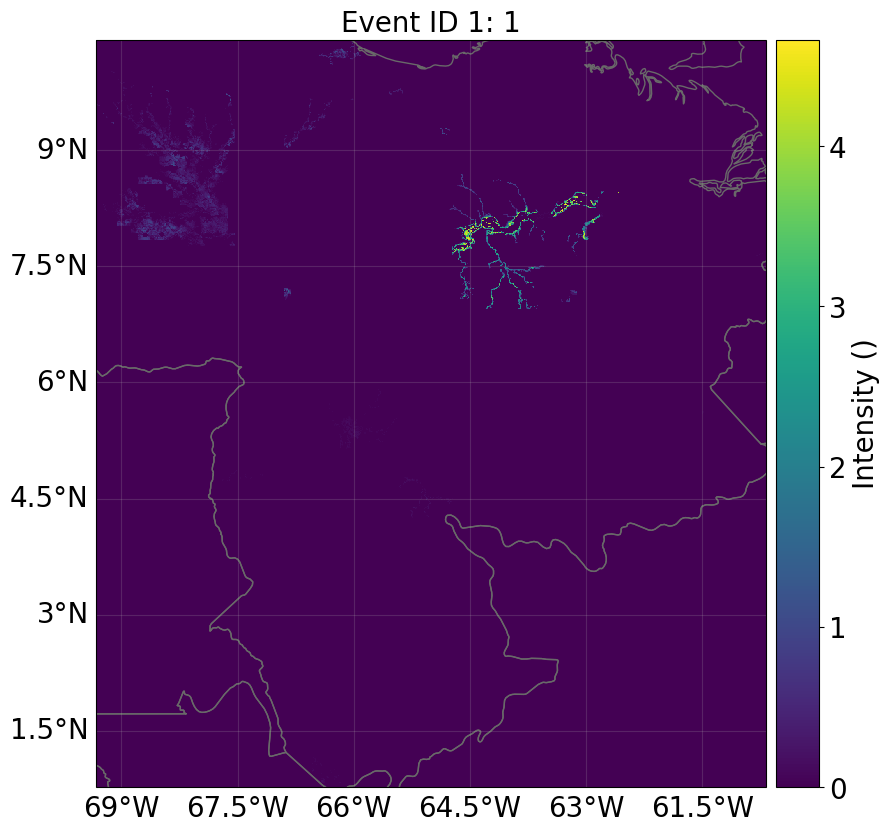

In [1]:
%matplotlib inline
import numpy as np
from climada.hazard import Hazard
from climada.util.constants import HAZ_DEMO_FL

# to hide the warnings
import warnings

warnings.filterwarnings("ignore")

# read intensity from raster file HAZ_DEMO_FL and set frequency for the contained event
haz_ven = Hazard.from_raster(
    [HAZ_DEMO_FL], attrs={"frequency": np.ones(1) / 2}, haz_type="FL"
)
haz_ven.check()

# The masked values of the raster are set to 0
# Sometimes the raster file does not contain all the information, as in this case the mask value -9999
# We mask it manuall and plot it using plot_intensity()
haz_ven.intensity[haz_ven.intensity == -9999] = 0
haz_ven.plot_intensity(
    1, smooth=False
)  # if smooth=True (default value) is used, the computation time might increase

# per default the following attributes have been set
print("event_id: ", haz_ven.event_id)
print("event_name: ", haz_ven.event_name)
print("date: ", haz_ven.date)
print("frequency: ", haz_ven.frequency)
print("orig: ", haz_ven.orig)
print("min, max fraction: ", haz_ven.fraction.min(), haz_ven.fraction.max())

### EXERCISE:

1. Read raster data in EPSG 2201 Coordinate Reference System (CRS)
2. Read raster data in its given CRS and transform it to the affine transformation Affine(0.009000000000000341, 0.0, -69.33714959699981, 0.0, -0.009000000000000341, 10.42822096697894), height=500, width=501)
3. Read raster data in window Window(10, 10, 20, 30)

In [2]:
# Put your code here

In [3]:
# Solution:

# 1. The CRS can be reprojected using dst_crs option
haz = Hazard.from_raster([HAZ_DEMO_FL], dst_crs="epsg:2201", haz_type="FL")
haz.check()
print("\n Solution 1:")
print("centroids CRS:", haz.centroids.crs)
print("raster info:", haz.centroids.get_meta())

# 2. Transformations of the coordinates can be set using the transform option and Affine
from rasterio import Affine

haz = Hazard.from_raster(
    [HAZ_DEMO_FL],
    haz_type="FL",
    transform=Affine(
        0.009000000000000341,
        0.0,
        -69.33714959699981,
        0.0,
        -0.009000000000000341,
        10.42822096697894,
    ),
    height=500,
    width=501,
)
haz.check()
print("\n Solution 2:")
print("raster info:", haz.centroids.get_meta())
print("intensity size:", haz.intensity.shape)

# 3. A partial part of the raster can be loaded using the window or geometry
from rasterio.windows import Window

haz = Hazard.from_raster([HAZ_DEMO_FL], haz_type="FL", window=Window(10, 10, 20, 30))
haz.check()
print("\n Solution 3:")
print("raster info:", haz.centroids.get_meta())
print("intensity size:", haz.intensity.shape)

2024-10-01 15:52:28,978 - climada.util.coordinates - INFO - Reading /Users/vgebhart/climada/demo/data/SC22000_VE__M1.grd.gz
2024-10-01 15:52:31,035 - climada.util.coordinates - INFO - Reading /Users/vgebhart/climada/demo/data/SC22000_VE__M1.grd.gz

 Solution 1:
centroids CRS: epsg:2201
raster info: {'crs': <Projected CRS: EPSG:2201>
Name: REGVEN / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Venezuela - west of 72°W.
- bounds: (-73.38, 7.02, -71.99, 11.62)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: Red Geodesica Venezolana
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
, 'height': 1091, 'width': 978, 'transform': Affine(1011.5372910988517, 0.0, 1120744.5486664253,
       0.0, -1011.5372910988517, 1189133.7652687666)}
2024-10-01 15:52:32,933 - climada.util.coordinates - INFO - Reading /Users/vgebhart/climada/demo/data/SC22000_VE__M1.grd.gz
2024-10-01 15:52:34,619 - climada.util.co

<a id='Part2'></a> 
## Part 2: Read hazards from other data

- excel: Hazards can be read from Excel files following the template in `climada_python/climada/data/system/hazard_template.xlsx` using the `from_excel()` method. 
- MATLAB: Hazards generated with CLIMADA's MATLAB version (.mat format) can be read using `from_mat()`.
- vector data: Use `Hazard`'s `from_vector`-constructor to read shape data (all formats supported by [fiona](https://fiona.readthedocs.io/en/latest/manual.html)).
- hdf5: Hazards generated with the CLIMADA in Python (.h5 format) can be read using `from_hdf5()`.


In [4]:
from climada.hazard import Hazard, Centroids
from climada.util import HAZ_DEMO_H5  # CLIMADA's Python file

# Hazard needs to know the acronym of the hazard type to be constructed!!! Use 'NA' if not known.
haz_tc_fl = Hazard.from_hdf5(
    HAZ_DEMO_H5
)  # Historic tropical cyclones in Florida from 1990 to 2004
haz_tc_fl.check()  # Use always the check() method to see if the hazard has been loaded correctly

2024-10-01 15:52:36,511 - climada.hazard.io - INFO - Reading /Users/vgebhart/climada/demo/data/tc_fl_1990_2004.h5


<a id='Part3'></a> 
## Part 3: Define hazards manually
A `Hazard` can be defined by filling its values one by one, as follows:

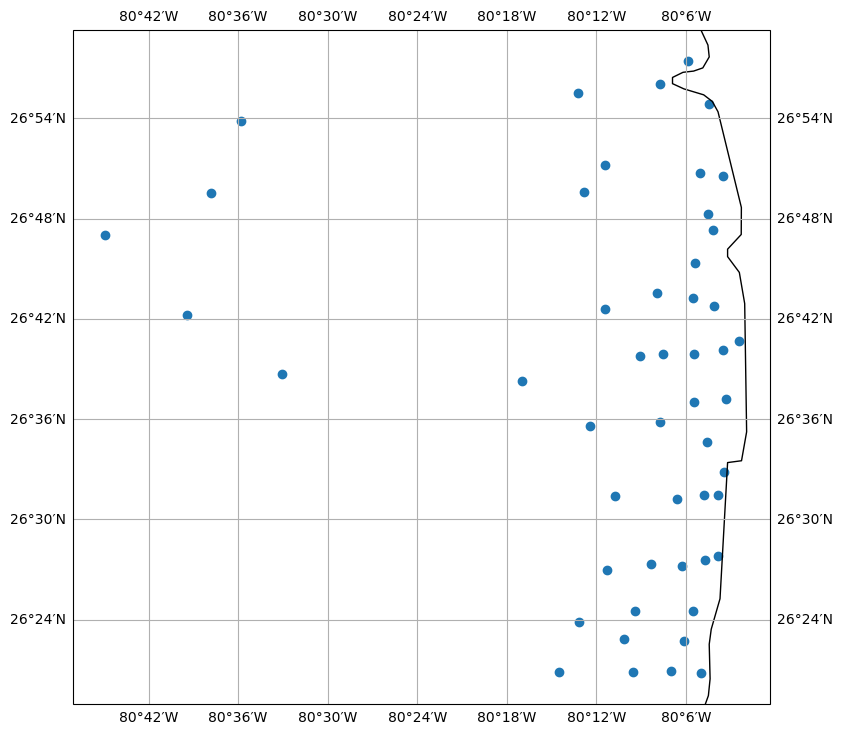

In [5]:
# setting points
import numpy as np
from scipy import sparse

lat = np.array(
    [
        26.933899,
        26.957203,
        26.783846,
        26.645524,
        26.897796,
        26.925359,
        26.914768,
        26.853491,
        26.845099,
        26.82651,
        26.842772,
        26.825905,
        26.80465,
        26.788649,
        26.704277,
        26.71005,
        26.755412,
        26.678449,
        26.725649,
        26.720599,
        26.71255,
        26.6649,
        26.664699,
        26.663149,
        26.66875,
        26.638517,
        26.59309,
        26.617449,
        26.620079,
        26.596795,
        26.577049,
        26.524585,
        26.524158,
        26.523737,
        26.520284,
        26.547349,
        26.463399,
        26.45905,
        26.45558,
        26.453699,
        26.449999,
        26.397299,
        26.4084,
        26.40875,
        26.379113,
        26.3809,
        26.349068,
        26.346349,
        26.348015,
        26.347957,
    ]
)

lon = np.array(
    [
        -80.128799,
        -80.098284,
        -80.748947,
        -80.550704,
        -80.596929,
        -80.220966,
        -80.07466,
        -80.190281,
        -80.083904,
        -80.213493,
        -80.0591,
        -80.630096,
        -80.075301,
        -80.069885,
        -80.656841,
        -80.190085,
        -80.08955,
        -80.041179,
        -80.1324,
        -80.091746,
        -80.068579,
        -80.090698,
        -80.1254,
        -80.151401,
        -80.058749,
        -80.283371,
        -80.206901,
        -80.090649,
        -80.055001,
        -80.128711,
        -80.076435,
        -80.080105,
        -80.06398,
        -80.178973,
        -80.110519,
        -80.057701,
        -80.064251,
        -80.07875,
        -80.139247,
        -80.104316,
        -80.188545,
        -80.21902,
        -80.092391,
        -80.1575,
        -80.102028,
        -80.16885,
        -80.116401,
        -80.08385,
        -80.241305,
        -80.158855,
    ]
)

n_cen = lon.size  # number of centroids
n_ev = 10  # number of events

intensity = sparse.csr_matrix(np.random.random((n_ev, n_cen)))
fraction = intensity.copy()
fraction.data.fill(1)

haz = Hazard(
    haz_type="TC",
    intensity=intensity,
    fraction=fraction,
    centroids=Centroids(lat=lat, lon=lon),  # default crs used
    units="m",
    event_id=np.arange(n_ev, dtype=int),
    event_name=[
        "ev_12",
        "ev_21",
        "Maria",
        "ev_35",
        "Irma",
        "ev_16",
        "ev_15",
        "Edgar",
        "ev_1",
        "ev_9",
    ],
    date=np.array(
        [721166, 734447, 734447, 734447, 721167, 721166, 721167, 721200, 721166, 721166]
    ),
    orig=np.zeros(n_ev, bool),
    frequency=np.ones(n_ev) / n_ev,
)

haz.check()
haz.centroids.plot();

Or the `Hazard` can be defined with a grid:

In [6]:
# using from_pnt_bounds

# bounds
left, bottom, right, top = (
    -72,
    -3.0,
    -52.0,
    22,
)  # the bounds refer to the bounds of the center of the pixel
# resolution
res = 0.5
centroids = Centroids.from_pnt_bounds(
    (left, bottom, right, top), res
)  # default crs used

In [7]:
# the same can be done with the method `from_meta`, by definition of a raster meta object

import rasterio
from climada.util.constants import DEF_CRS

# raster info:
# border upper left corner (of the pixel, not of the center of the pixel)
max_lat = top + res / 2
min_lon = left - res / 2
# resolution in lat and lon
d_lat = -res  # negative because starting in upper corner
d_lon = res  # same step as d_lat
# number of points
n_lat, n_lon = centroids.shape

# meta: raster specification
meta = {
    "dtype": "float32",
    "width": n_lon,
    "height": n_lat,
    "crs": DEF_CRS,
    "transform": rasterio.Affine(a=d_lon, b=0.0, c=min_lon, d=0.0, e=d_lat, f=max_lat),
}

centroids_from_meta = Centroids.from_meta(meta)  # default crs used

centroids_from_meta == centroids

True

Check centroids borders: [-72.  -3. -52.  22.]


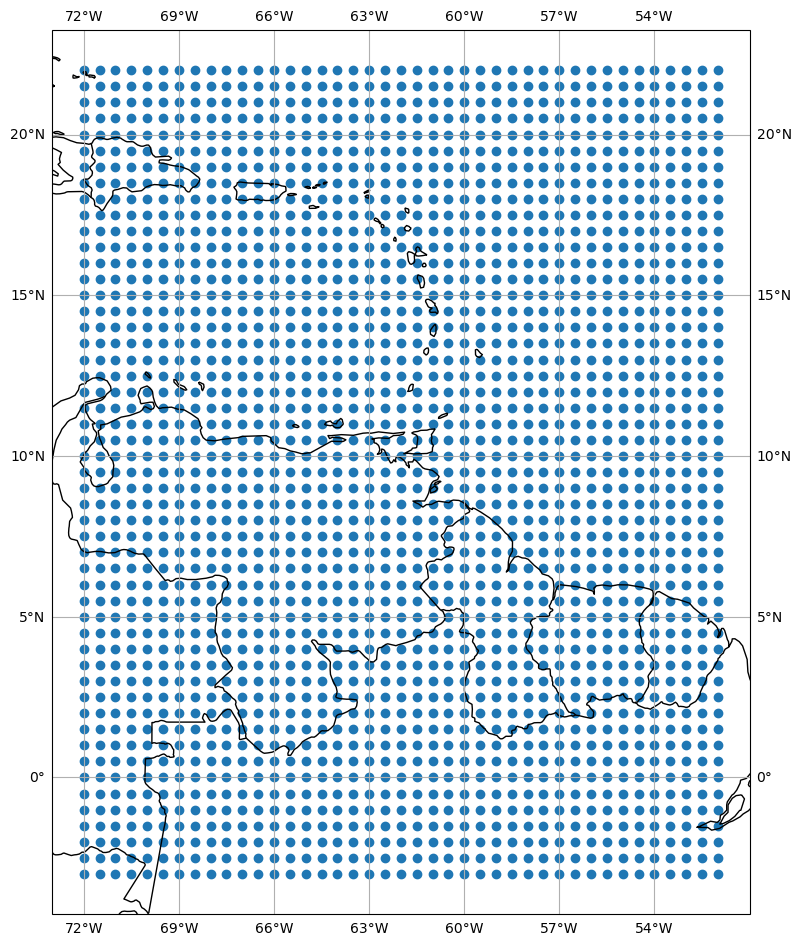

In [8]:
# create a Hazard object with random events

import numpy as np
from scipy import sparse

n_ev = 10  # number of events

intensity = sparse.csr_matrix(np.random.random((n_ev, centroids.size)))
fraction = intensity.copy()
fraction.data.fill(1)

haz = Hazard(
    "TC",
    centroids=centroids,
    intensity=intensity,
    fraction=fraction,
    units="m",
    event_id=np.arange(n_ev, dtype=int),
    event_name=[
        "ev_12",
        "ev_21",
        "Maria",
        "ev_35",
        "Irma",
        "ev_16",
        "ev_15",
        "Edgar",
        "ev_1",
        "ev_9",
    ],
    date=np.array(
        [721166, 734447, 734447, 734447, 721167, 721166, 721167, 721200, 721166, 721166]
    ),
    orig=np.zeros(n_ev, bool),
    frequency=np.ones(n_ev) / n_ev,
)

haz.check()
print("Check centroids borders:", haz.centroids.total_bounds)
haz.centroids.plot();

<a id='Part4'></a> 
## Part 4: Analyse Hazards

The following methods can be used to analyse the data in `Hazard`:

- `calc_year_set()` method returns a dictionary with all the historical (not synthetic) event ids that happened at each year. 
- `get_event_date()` returns strings of dates in ISO format.
- To obtain the relation between event ids and event names, two methods can be used `get_event_name()` and `get_event_id()`. 

Other methods to handle one or several Hazards are:
- the property `size` returns the number of events contained.
- `append()` is used to expand events with data from another `Hazard` (and same centroids).
- `select()` returns a new hazard with the selected region, date and/or synthetic or historical filter.
- `remove_duplicates()` removes events with same name and date.
- `local_exceedance_intensity()` returns a gdf.GeoDataFrame with the exceedence frequency at every frequency and provided return periods.
- `local_return_period()` returns a gdf.GeoDataFrame with the return periods at every centroid for user-specified threshold intensities. 
- `reproject_vector()` is a method to change the centroids' CRS. 

`Centroids` methods:
- centroids properties such as area per pixel, distance to coast, country ISO code, on land mask or elevation are available through different `set_XX()`methods.
- `set_lat_lon_to_meta()` computes the raster `meta` dictionary from present lat and lon. `set_meta_to_lat_lon()` computes lat and lon of the center of the pixels described in attribute `meta`. The raster `meta` information contains at least: `width`, `height`, `crs` and `transform` data (use help(Centroids) for more info). Using raster centroids can increase computing performance for several computations.
- when using lats and lons (vector data) the `geopandas.GeoSeries` `geometry` attribute contains the CRS information and can be filled with point shapes to perform different computation. The geometry points can be then released using `empty_geometry_points()`.

### EXERCISE:

Using the previous hazard `haz_tc_fl` answer these questions:
1. How many synthetic events are contained?
2. Generate a hazard with historical hurricanes ocurring between 1995 and 2001.
3. How many historical hurricanes occured in 1999? Which was the year with most hurricanes between 1995 and 2001?
4. What is the number of centroids with distance to coast smaller than 1km?

In [9]:
# Put your code here:

In [10]:
# help(hist_tc.centroids) # If you want to run it, do it after you execute the next block

In [11]:
# SOLUTION:

# 1.How many synthetic events are contained?
print("Number of total events:", haz_tc_fl.size)
print("Number of synthetic events:", np.logical_not(haz_tc_fl.orig).astype(int).sum())

# 2. Generate a hazard with historical hurricanes ocurring between 1995 and 2001.
hist_tc = haz_tc_fl.select(date=("1995-01-01", "2001-12-31"), orig=True)
print("Number of historical events between 1995 and 2001:", hist_tc.size)

# 3. How many historical hurricanes occured in 1999? Which was the year with most hurricanes between 1995 and 2001?
ev_per_year = hist_tc.calc_year_set()  # events ids per year
print("Number of events in 1999:", ev_per_year[1999].size)
max_year = 1995
max_ev = ev_per_year[1995].size
for year, ev in ev_per_year.items():
    if ev.size > max_ev:
        max_year = year
print("Year with most hurricanes between 1995 and 2001:", max_year)

# 4. What is the number of centroids with distance to coast smaller than 1km?
num_cen_coast = np.argwhere(hist_tc.centroids.get_dist_coast() < 1000).size
print("Number of centroids close to coast: ", num_cen_coast)

Number of total events: 216
Number of synthetic events: 0
Number of historical events between 1995 and 2001: 109
Number of events in 1999: 16
Year with most hurricanes between 1995 and 2001: 1995
2024-10-01 15:52:37,708 - climada.util.coordinates - INFO - Sampling from /Users/vgebhart/climada/data/GMT_intermediate_coast_distance_01d.tif
Number of centroids close to coast:  67


<a id='Part5'></a> 
## Part 5: Visualize Hazards

There are three different plot functions: `plot_intensity()`, `plot_fraction()`, and `plot_rp_intensity()`. Depending on the inputs, different properties can be visualized. Check the documentation of the functions. Using the function `local_return_period()` and the util function `plot_from_gdf()`, one can plot local return periods for specific hazard intensities.

In [12]:
help(haz_tc_fl.plot_intensity)
help(haz_tc_fl.plot_rp_intensity)

Help on method plot_intensity in module climada.hazard.plot:

plot_intensity(event=None, centr=None, smooth=True, axis=None, adapt_fontsize=True, **kwargs) method of climada.hazard.base.Hazard instance
    Plot intensity values for a selected event or centroid.
    
    Parameters
    ----------
    event: int or str, optional
        If event > 0, plot intensities of
        event with id = event. If event = 0, plot maximum intensity in
        each centroid. If event < 0, plot abs(event)-largest event. If
        event is string, plot events with that name.
    centr: int or tuple, optional
        If centr > 0, plot intensity
        of all events at centroid with id = centr. If centr = 0,
        plot maximum intensity of each event. If centr < 0,
        plot abs(centr)-largest centroid where higher intensities
        are reached. If tuple with (lat, lon) plot intensity of nearest
        centroid.
    smooth: bool, optional
        Rescale data to RESOLUTIONxRESOLUTION pixels (s

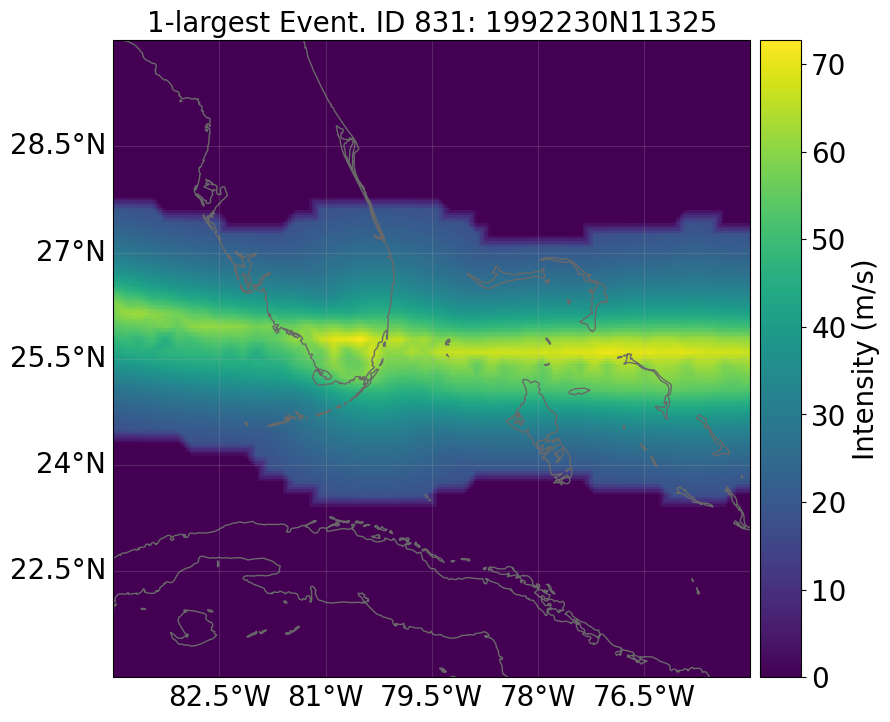

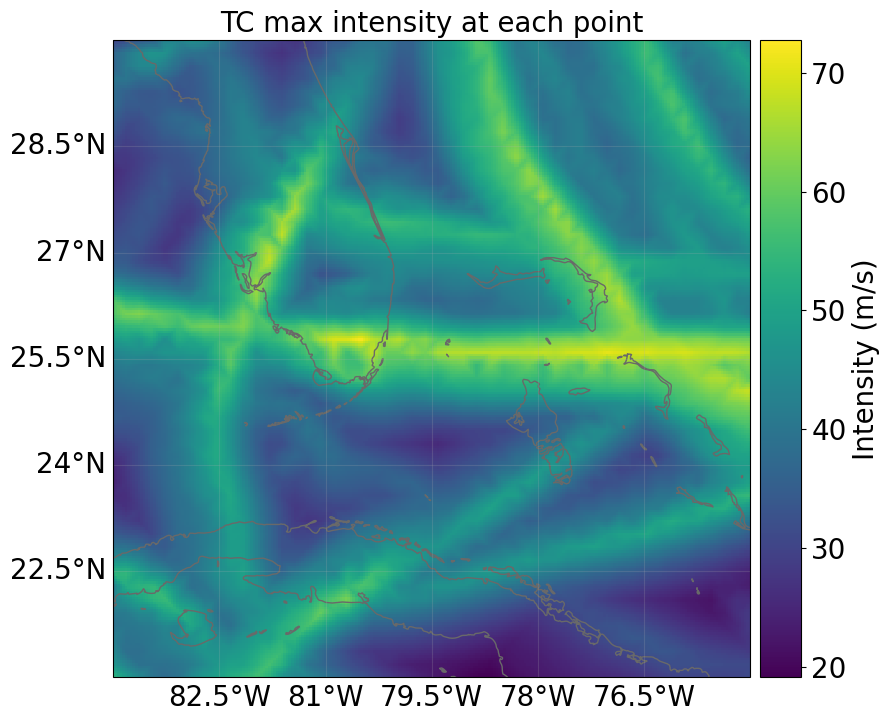

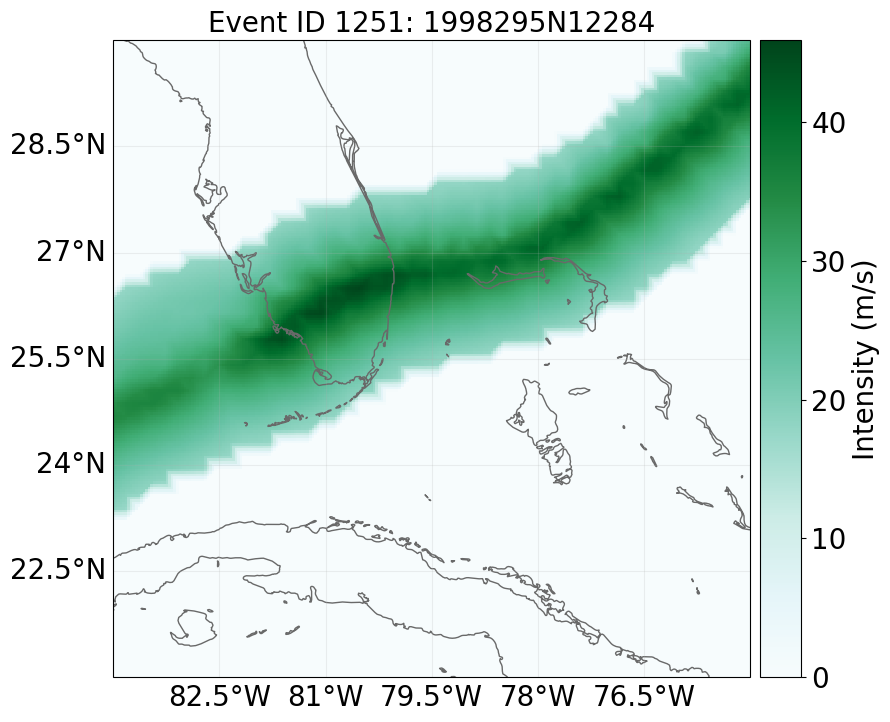

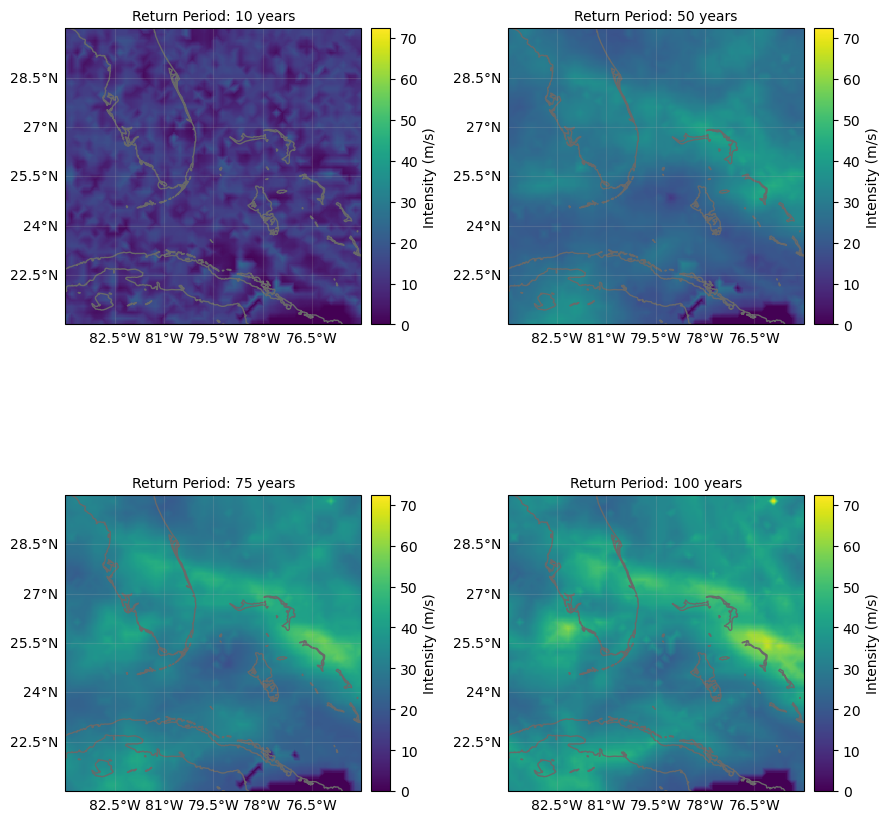

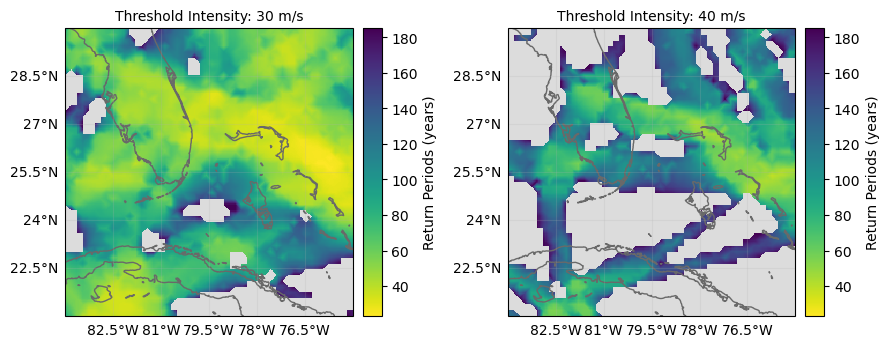

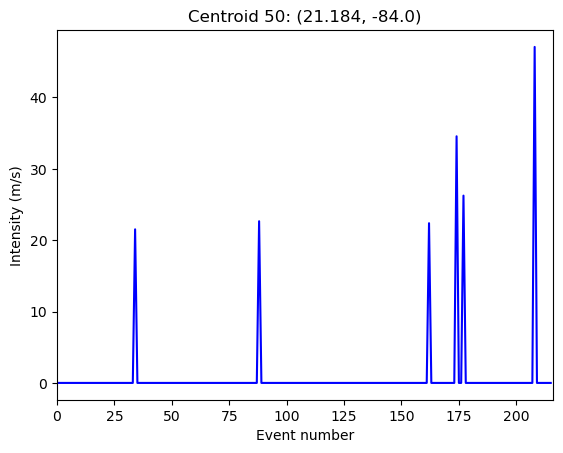

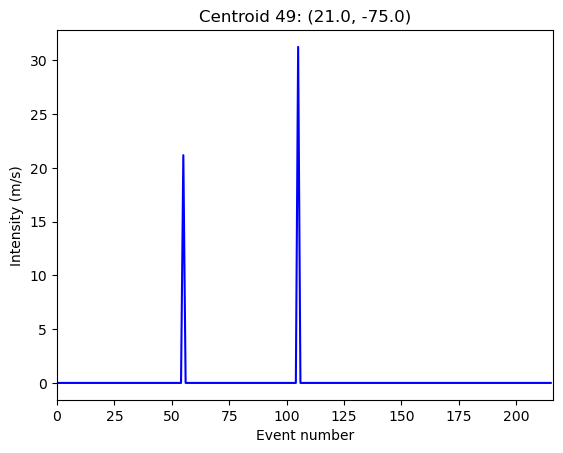

In [13]:
# 1. intensities of the largest event (defined as greater sum of intensities):
# all events:
haz_tc_fl.plot_intensity(
    event=-1
)  # largest historical event: 1992230N11325 hurricane ANDREW

# 2. maximum intensities at each centroid:
haz_tc_fl.plot_intensity(event=0)

# 3. intensities of hurricane 1998295N12284:
haz_tc_fl.plot_intensity(event="1998295N12284", cmap="BuGn")  # setting color map

# 4. tropical cyclone intensities maps for the return periods [10, 50, 75, 100]
exceedance_intensities, label, column_label = haz_tc_fl.local_exceedance_intensity(
    [10, 50, 75, 100], method="extrapolate"
)
from climada.util.plot import plot_from_gdf

plot_from_gdf(exceedance_intensities, colorbar_name=label, title_subplots=column_label)

# 5. tropical cyclone return period maps for the threshold intensities [30, 40]
return_periods, label, column_label = haz_tc_fl.local_return_period([30, 40])
plot_from_gdf(return_periods, colorbar_name=label, title_subplots=column_label)

# 6. intensities of all the events in centroid with id 50
haz_tc_fl.plot_intensity(centr=50)

# 7. intensities of all the events in centroid closest to lat, lon = (26.5, -81)
haz_tc_fl.plot_intensity(centr=(26.5, -81));

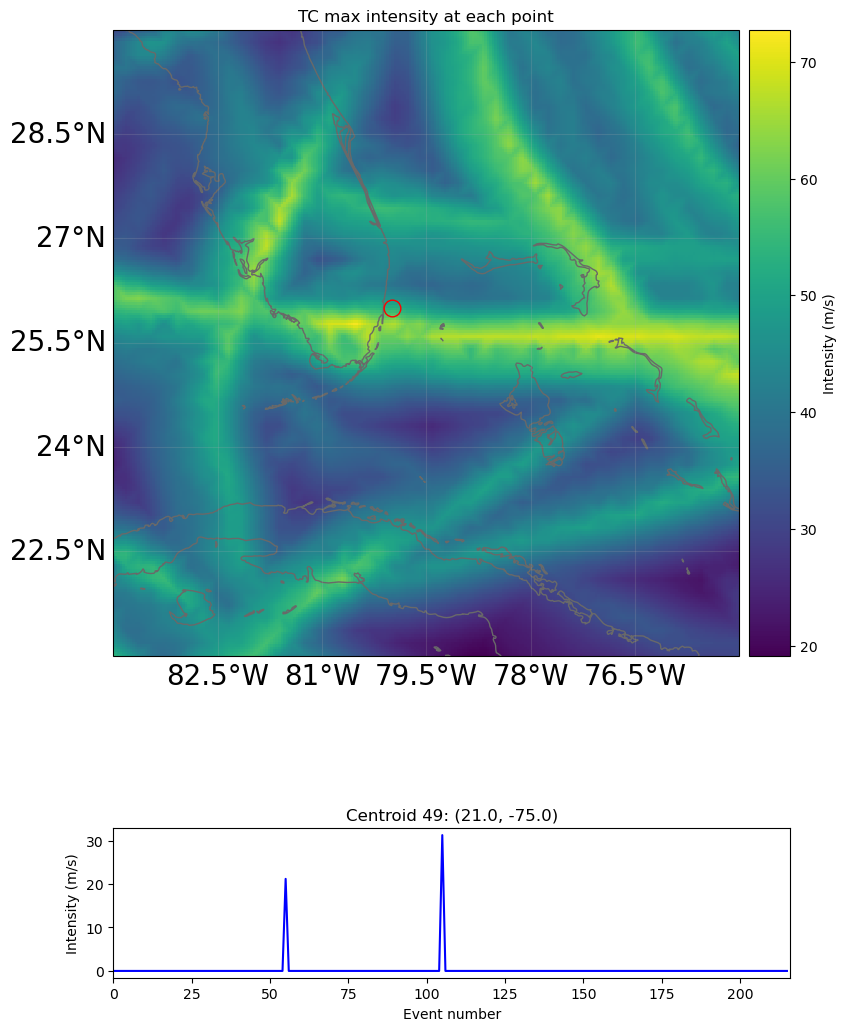

In [14]:
# 7. one figure with two plots: maximum intensities and selected centroid with all intensities:
from climada.util.plot import make_map
import matplotlib.pyplot as plt

fig, ax1, fontsize = make_map(1)  # map
ax2 = fig.add_subplot(2, 1, 2)  # add regular axes
haz_tc_fl.plot_intensity(axis=ax1, event=0)  # plot original resolution
ax1.plot(-80, 26, "or", mfc="none", markersize=12)
haz_tc_fl.plot_intensity(axis=ax2, centr=(26, -80))
fig.subplots_adjust(hspace=6.5)

<a id='Part6'></a> 
## Part 6: Write (=save) hazards

Hazards can be written and read in hdf5 format as follows:

In [15]:
# If you see an error message, try to create a depository named results in the repository tutorial.
haz_tc_fl.write_hdf5("results/haz_tc_fl.h5")

haz = Hazard.from_hdf5("results/haz_tc_fl.h5")
haz.check()

2024-10-01 15:53:40,418 - climada.hazard.io - INFO - Writing results/haz_tc_fl.h5
2024-10-01 15:53:40,443 - climada.hazard.centroids.centr - INFO - Writing results/haz_tc_fl.h5
2024-10-01 15:53:40,461 - climada.hazard.io - INFO - Reading results/haz_tc_fl.h5


GeoTiff data is generated using `write_raster()`:

In [16]:
haz_ven.write_raster("results/haz_ven.tif")  # each event is a band of the tif file

2024-10-01 15:53:40,758 - climada.util.coordinates - INFO - Writting results/haz_ven.tif


Pickle will work as well, but note that pickle has a [transient format](saving-with-pickle) and should be avoided when possible:

In [17]:
from climada.util.save import save

# this generates a results folder in the current path and stores the output there
save("tutorial_haz_tc_fl.p", haz_tc_fl)

2024-10-01 15:53:40,772 - climada.util.save - INFO - Written file /Users/vgebhart/Documents/climada/outputs/temp/tutorial_haz_tc_fl.p
